- check  0, 1 count in train, valid and test for different multilabel stratified fold seeds

In [1]:
import sys
sys.path.append('../input/iterativestratification')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import indexable
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def ThreeWaySplitKFold(T):

    class kfold_class(T):

        def __init__(self, n_splits=10, **kwargs):
            super().__init__(n_splits=n_splits, **kwargs)

        def split(self, X, y=None, groups=None):
            splits = []
            for _, index in super().split(X,y,groups):
                splits.append(index)
            assert self.n_splits == len(splits)

            X, y, groups = indexable(X, y, groups)
            indices = np.arange(len(X))
            for i,test_index in enumerate(splits):
                valid_index = splits[(i+1)%self.n_splits]
                mask = np.full(len(X), True)
                mask[test_index] = False
                mask[valid_index] = False
                train_index = indices[mask]
                yield train_index, valid_index, test_index

    return kfold_class

In [3]:
def training(x, y, stratify):
    
    for index_, seed in enumerate(range(100)):
        cv = ThreeWaySplitKFold(MultilabelStratifiedKFold)(5,shuffle=True,random_state=seed)
        for split, (train_idx, val_idx, test_idx) in enumerate(cv.split(x, stratify)):
                
            x_train, x_val, x_test = x.iloc[train_idx], x.iloc[val_idx], x.iloc[test_idx]
            y_train, y_val, y_test = y.iloc[train_idx], y.iloc[val_idx], y.iloc[test_idx]
        
            train_split = np.bincount(y_train.astype(int))
            valid_split = np.bincount(y_val.astype(int))
            test_split = np.bincount(y_val.astype(int))
        
            if split ==0:
                train_count = np.bincount(y_train)
                valid_count = np.bincount(y_val)
                test_count = np.bincount(y_test)

            else:
                train_count = np.append(train_count, np.bincount(y_train))
                valid_count = np.append(valid_count, np.bincount(y_val))
                test_count = np.append(test_count, np.bincount(y_test))

        if index_ == 0:
            train0 = train_count[0::2] # 各foldのtrain_dataのlabel 0の個数
            train1 = train_count[1::2]
            valid0 = valid_count[0::2]
            valid1 = valid_count[1::2]
            test0 = test_count[0::2]
            test1 = test_count[1::2]
        else:
            train0 = np.append(train0, train_count[0::2])
            train1 = np.append(train1, train_count[1::2])
            valid0 = np.append(valid0, valid_count[0::2])
            valid1 = np.append(valid1, valid_count[1::2])
            test0 = np.append(test0, valid_count[0::2])
            test1 = np.append(test1, valid_count[1::2])

    plt.figure(figsize=(15, 6)) 
    plt.subplot(1,3,1)
    sns.histplot(train0)
    sns.histplot(train1)
    plt.subplot(1,3,2)
    sns.histplot(valid0)
    sns.histplot(valid1)
    plt.subplot(1,3,3)
    sns.histplot(test0)
    sns.histplot(test1)

In [4]:
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
sample = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
train = pd.merge(train, greeks, on = "Id", how = "inner")

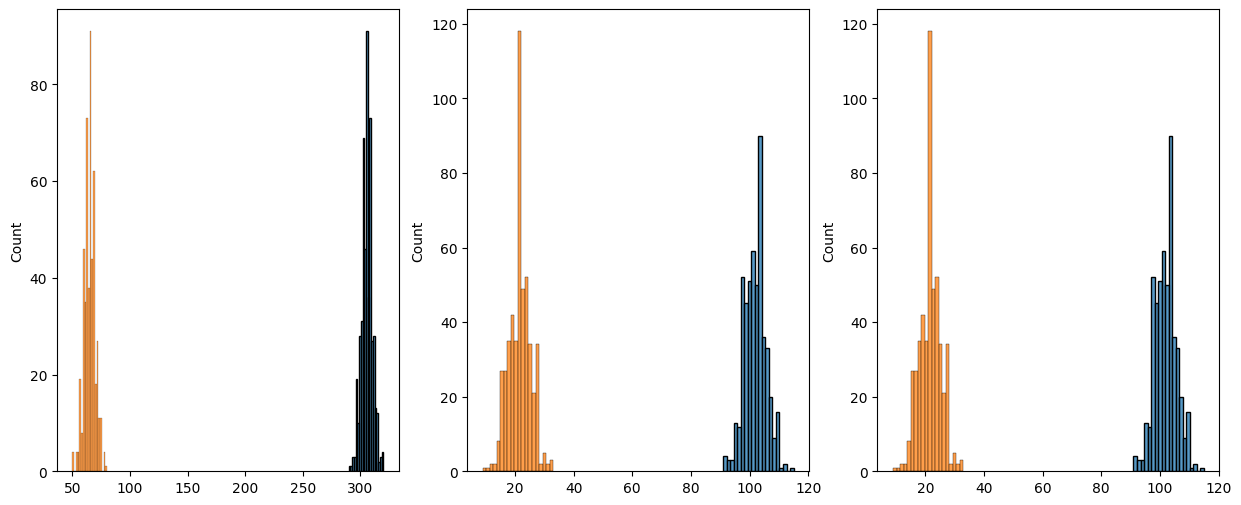

In [5]:
stratify = train[["Beta", "Delta", "Gamma"]] 
training(train, train.Class, stratify)

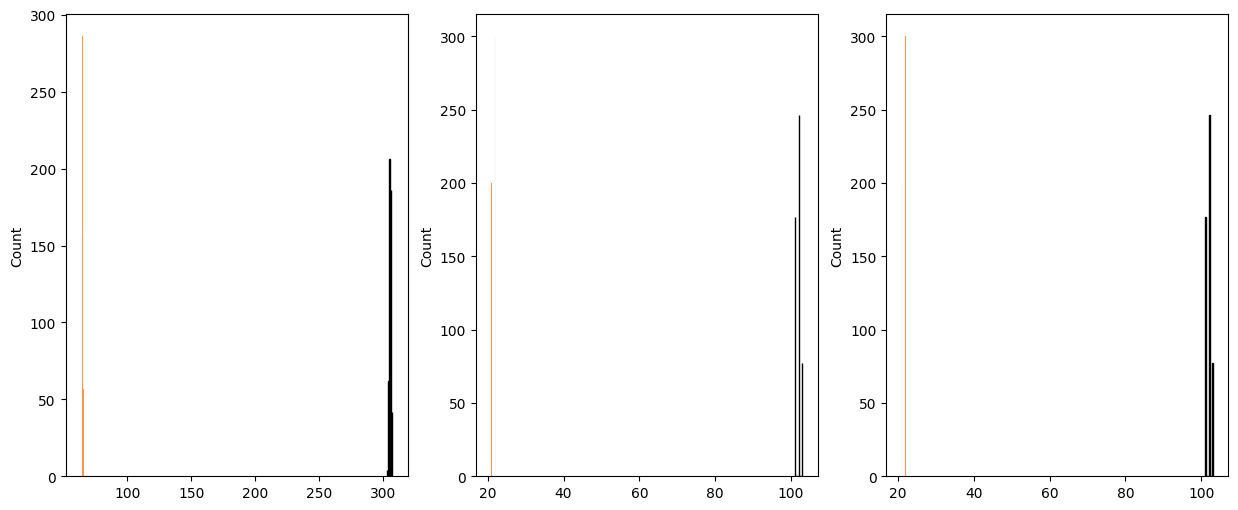

In [6]:
stratify = train[["Class", "Beta", "Delta", "Gamma"]] 
training(train, train.Class, stratify)